In [1]:
!pip install scanpy
!pip install KDEpy
!pip install leidenalg

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


# Analysis of clusters in sample S3

In [2]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr, kendalltau

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.ClusterDE as cd

import importlib

## Preprocessing
### Read data

In [3]:
data_path = "../../data/BacDrop"
data_gene = sc.read_h5ad(data_path + "/antibiotics_data_processed_3.h5ad")


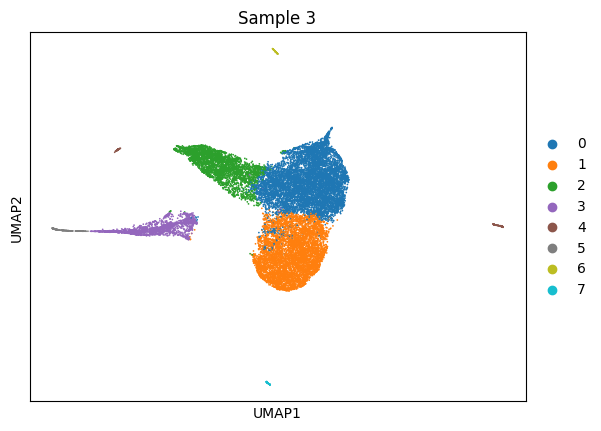

In [4]:
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

## Generate synthetic null data for ClusterDE

### Estimate distribution and parameters for every gene

In [5]:
importlib.reload(nb)
import warnings
warnings.filterwarnings("ignore")
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="statsmod_auto")


gene 0
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 100
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 200
Both NB and ZINB not converged! Using NB without starting params


In [6]:
data_gene.var

n_cells_by_counts  mean_counts  log1p_mean_counts  \
cds-AF52_RS00165                   13     0.000662           0.000662   
cds-AF52_RS00180                    2     0.000102           0.000102   
cds-AF52_RS00620                   14     0.000713           0.000713   
cds-AF52_RS01010                    2     0.000102           0.000102   
cds-AF52_RS01075                    3     0.000153           0.000153   
...                               ...          ...                ...   
cds-WP_187079188.1                  9     0.000458           0.000458   
cds-WP_187079189.1                 24     0.001273           0.001272   
cds-WP_187079194.1                 39     0.002037           0.002035   
cds-WP_187079196.1                 21     0.001171           0.001171   
cds-WP_187079197.1                 11     0.000560           0.000560   

                    pct_dropout_by_counts  total_counts  log1p_total_counts  \
cds-AF52_RS00165                99.933802          13.0            2.639057   
cds-AF52_RS00180                99.989816           2.0            1.098612   
cds-AF52_RS00620                99.928710          14.0            2.708050   
cds-AF52_RS01010                99.989816           2.0            1.098612   
cds-AF52_RS01075                99.984723           3.0            1.386294   
...                                   ...           ...                 ...   
cds-WP_187079188.1              99.954170           9.0            2.302585   
cds-WP_187079189.1              99.877788          25.0            3.258096   
cds-WP_187079194.1              99.801405          40.0            3.713572   
cds-WP_187079196.1              99.893064          23.0            3.178054   
cds-WP_187079197.1              99.943986          11.0            2.484907   

                    n_cells  var_counts  is_scd_outlier  nb_overdisp  ...  \
cds-AF52_RS00165         13    0.000661           False     0.015929  ...   
cds-AF52_RS00180          2    0.000102           False     0.000202  ...   
cds-AF52_RS00620         14    0.000713           False     0.026059  ...   
cds-AF52_RS01010          2    0.000102           False     0.000202  ...   
cds-AF52_RS01075          3    0.000153           False     0.000238  ...   
...                     ...         ...             ...          ...  ...   
cds-WP_187079188.1        9    0.000458           False     0.021694  ...   
cds-WP_187079189.1       24    0.001373           False     0.024587  ...   
cds-WP_187079194.1       39    0.002134           False     0.028569  ...   
cds-WP_187079196.1       21    0.001374           False     0.019140  ...   
cds-WP_187079197.1       11    0.000560           False     0.016529  ...   

                    product_accession  \
cds-AF52_RS00165                  NaN   
cds-AF52_RS00180                  NaN   
cds-AF52_RS00620                  NaN   
cds-AF52_RS01010                  NaN   
cds-AF52_RS01075                  NaN   
...                               ...   
cds-WP_187079188.1     WP_187079188.1   
cds-WP_187079189.1     WP_187079189.1   
cds-WP_187079194.1     WP_187079194.1   
cds-WP_187079196.1     WP_187079196.1   
cds-WP_187079197.1     WP_187079197.1   

                                                                 name  symbol  \
cds-AF52_RS00165                                  diguanylate cyclase     NaN   
cds-AF52_RS00180                         PTS transporter subunit EIIC     NaN   
cds-AF52_RS00620            sugar ABC transporter ATP-binding protein     NaN   
cds-AF52_RS01010                                                  NaN     NaN   
cds-AF52_RS01075                               DUF5347 family protein     NaN   
...                                                               ...     ...   
cds-WP_187079188.1                            DNA replication protein     NaN   
cds-WP_187079189.1                                     ribonuclease D     rnd   
cds-WP_187079194.1                             

## Find optimal correlation matrix scaling and generate synthetic null data

In [7]:
importlib.reload(cd)
try:
    xmin, fval, R_est_noscale = cd.select_covariance_scaling(data_gene, cor_cutoff=0.1, min_scale=1, max_scale=2, maxiter=20, rng_seed=1234)
except:
    _, R_est_noscale = cd.generate_nb_data_copula(data_gene, rng_seed=1234, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True, corr_factor=1,
                                                  R_est=None, check_pd=True)
    xmin = 1
print(xmin)

Factor: 1 - Error: 12.324504722335949
Factor: 2 - Error: 12.284151370031053
Factor: 3.6180339999999998 - Error: 12.393626604167189
Factor: 2 - Error: 12.284151370031053
Factor: 2.61803399102434 - Error: 12.398391195414273
Factor: 1.61803399 - Error: 12.360750710231427
Factor: 2.236067977595943 - Error: 12.38776269430018
Factor: 1.85410196720468 - Error: 12.32174858616288
Factor: 2.090169943491092 - Error: 12.34638297250272
Factor: 1.9442719105463224 - Error: 12.41130516102543
Factor: 2.034441853537218 - Error: 12.329126328750585
Factor: 1.9787137640264558 - Error: 12.30474507592227
Factor: 2.0131556173726155 - Error: 12.442398167885024
Factor: 1.991869381377267 - Error: 12.356787219348554
Factor: 2.0050249986769044 - Error: 12.362765379572762
Factor: 1.996894380045843 - Error: 12.30105970707915
Factor: 2.0019193786948724 - Error: 12.343444210444034
Factor: 1.9988137587375343 - Error: 12.334491661037477
Factor: 2.0007331374217596 - Error: 12.299781414988841
Factor: 1.9995468961580785 - 

In [8]:
importlib.reload(cd)

# Generate scaling matrix
cor_orig = cd.schaefer_strimmer(data_gene.layers["counts"].toarray(), use_corr=True)
factor_cor = (np.abs(cor_orig) > 0.1)
cf = factor_cor * xmin
cf[cf == 0] = 1
np.fill_diagonal(cf, 1)


In [9]:
importlib.reload(cd)
n, p = data_gene.X.shape
data_null_gen, R_est = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True, new_data_shape=(2*n, p),
                                                  corr_factor=cf, R_est=R_est_noscale, check_pd=False, min_nonzero=2)


In [10]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [11]:
data_gene_nonzero = data_gene[:, data_null_gen.var_names].copy()

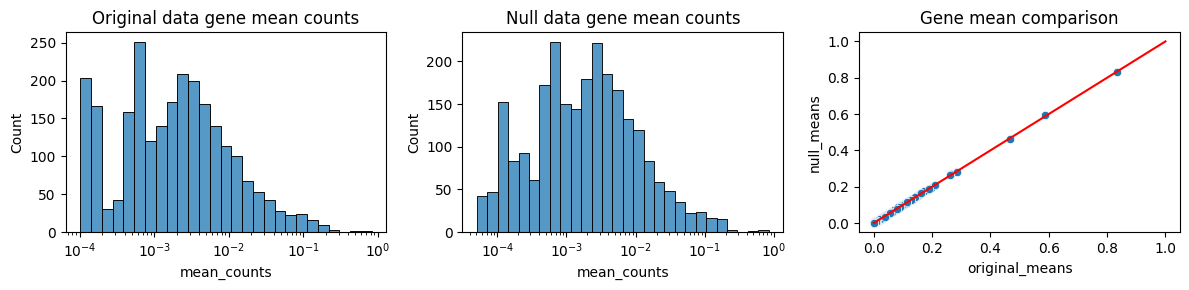

SignificanceResult(statistic=0.9937918479070709, pvalue=0.0)


In [12]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="mean_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene mean counts")
sns.histplot(data_null_gen.var, x="mean_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene mean counts")

mean_df_opt = pd.DataFrame({"original_means": data_gene_nonzero.var["mean_counts"], "null_means": data_null_gen.var["mean_counts"]})
sns.scatterplot(mean_df_opt, y="null_means", x="original_means", ax=ax[2])
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], color="red")
ax[2].set_title("Gene mean comparison")
plt.tight_layout()
plt.show()

print(spearmanr(mean_df_opt["original_means"], mean_df_opt["null_means"]))

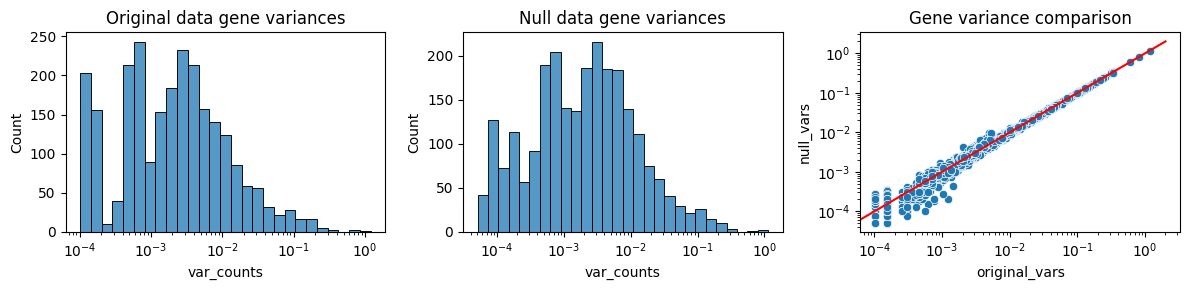

SignificanceResult(statistic=0.9907510958158807, pvalue=0.0)
[[1.         0.99950487]
 [0.99950487 1.        ]]


In [13]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="var_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene variances")
sns.histplot(data_null_gen.var, x="var_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene variances")

var_df_opt = pd.DataFrame({"original_vars": data_gene_nonzero.var["var_counts"], "null_vars": data_null_gen.var["var_counts"]})
var_df_opt["ratio"] = var_df_opt["null_vars"] / var_df_opt["original_vars"]
var_df_opt["diff"] = var_df_opt["null_vars"] - var_df_opt["original_vars"]

g = sns.scatterplot(var_df_opt, y="null_vars", x="original_vars", ax=ax[2])

g.set(xscale="log", yscale="log")
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], color="red")
ax[2].set_title("Gene variance comparison")
plt.tight_layout()
plt.show()

print(spearmanr(var_df_opt["original_vars"], var_df_opt["null_vars"]))
print(np.corrcoef(var_df_opt["original_vars"], var_df_opt["null_vars"]))

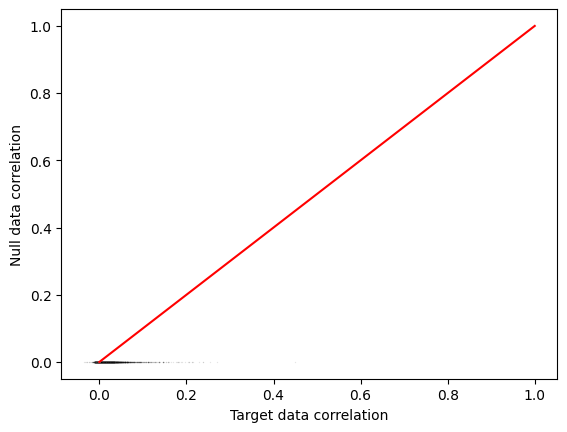

In [14]:
cor_shrink = cd.schaefer_strimmer(data_gene_nonzero.layers["counts"].toarray(), use_corr=True)
cor_shrink = pd.DataFrame(cor_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

cor_gen_shrink = cd.schaefer_strimmer(data_null_gen.X, use_corr=True)
cor_gen_shrink = pd.DataFrame(cor_gen_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

# Plot only 100.000 randomly sampled correlations instaed of ~30M
rng = np.random.default_rng(1234)
all_cors = pd.DataFrame({"cor_shrink": cor_shrink.values.flatten(), "cor_gen_shrink": cor_gen_shrink.values.flatten()})

ids = rng.choice(len(all_cors), 100000, replace=False)
all_cors_subset = all_cors.loc[ids]

sns.scatterplot(all_cors_subset[all_cors_subset['cor_shrink'] < 0.99], x="cor_shrink", y="cor_gen_shrink", s=1,
                color="black", alpha=0.1)
plt.plot([0, np.ceil(np.max(all_cors_subset['cor_shrink']))], [0, np.ceil(np.max(all_cors_subset['cor_shrink']))],
         color="red")
plt.xlabel("Target data correlation")
plt.ylabel("Null data correlation")

plt.show()

### Process null data

In [15]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [16]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_null_gen, flavor="sctransform", seed=1234)
data_null_gen.layers["counts"] = data_null_gen.X.copy()

k_opt = data_gene.uns["BacSC_params"]["k_opt"]
n_neighbors_opt = data_gene.uns["BacSC_params"]["n_neighbors_opt"]
min_dist_opt = data_gene.uns["BacSC_params"]["min_dist_opt"]
res_opt = data_gene.uns["BacSC_params"]["res_opt"]
print(n_neighbors_opt)

sc.pp.calculate_qc_metrics(data_null_gen, var_type="genes", percent_top=None, log1p=True, inplace=True)
sc.pp.normalize_total(data_null_gen, target_sum=None, layer=None)
data_null_gen.X = sps.csr_matrix(np.log(data_null_gen.X + np.array(data_null_gen.var["nb_overdisp"] / 4)))
data_null_gen.layers["vst_counts"] = data_null_gen.X.copy()
sc.pp.scale(data_null_gen, max_value=10, zero_center=True)
data_null_gen.X[np.isnan(data_null_gen.X)] = 0
sc.tl.pca(data_null_gen, svd_solver='arpack')
sc.pp.neighbors(data_null_gen, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_null_gen, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)


150


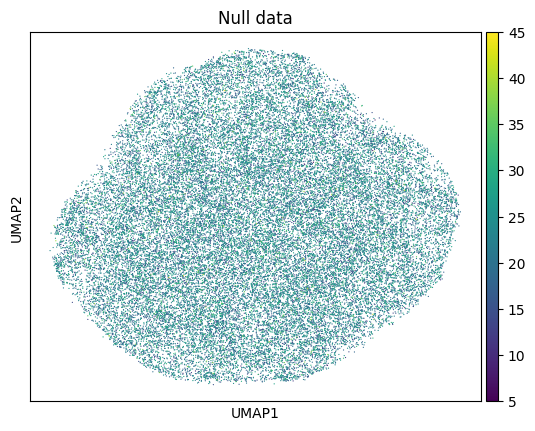

In [17]:
sc.pl.umap(data_null_gen, color="total_counts", alpha=1, cmap="viridis", title="Null data")
plt.show()


In [18]:
data_null_gen.write(data_path + "/null_data_antibiotics_2.h5ad")

In [19]:
data_null_gen = sc.read_h5ad(data_path + "/null_data_antibiotics_2.h5ad")
data_gene_nonzero = data_gene[:, data_null_gen.var_names].copy()

In [20]:
n_splits = 1
rng = np.random.default_rng(1234)
seeds = rng.choice(1000, n_splits)
null_pvals_dict = {}
min_pvals_null = []
c = 0
res_start = 0.01
res_step = 0.01

for s in seeds:
    res2 = res_start
    twoclust = False
    was_greater = False
    max_res_1_cluster = 0.01
    
    while twoclust is False:
        sc.tl.leiden(data_null_gen, resolution=res2, key_added=f"leiden_{c}", random_state=s)
        nclust = len(data_null_gen.obs[f"leiden_{c}"].unique())
        print(f"resolution: {res2}, clusters: {nclust}")

        if nclust == 2:
            twoclust = True
            break
        elif nclust < 2:
            if res2 > max_res_1_cluster:
                max_res_1_cluster = res2
            else: 
                res_step = res_step/2
            if was_greater:
                res2 += res_step
            else:
                res2 += 5*res_step
        else:
            was_greater = True
            min_res_2plus_clusters = res2
            res2 -= res_step
        res2 = np.round(res2, 15)

            
    X_null_gen_0 = data_null_gen.X[data_null_gen.obs[f"leiden_{c}"] == "0"]
    X_null_gen_1 = data_null_gen.X[data_null_gen.obs[f"leiden_{c}"] != "0"]
    null_pvals = ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue
    null_pvals_dict[c] = null_pvals

    clusters = data_gene.obs["leiden_opt"].unique()
            
    min_pvals_null.append(np.min(null_pvals))
            
    print(f"split {c+1}/{n_splits} - Resolution {res2}")

    res_start = res2 - 5*res_step
    c += 1
    
best_split = np.where(min_pvals_null == np.max(min_pvals_null))[0][0]
print(f"Best split: No. {best_split} - seed: {seeds[best_split]} - minimal p-value: {min_pvals_null[best_split]}")

resolution: 0.01, clusters: 1
resolution: 0.035, clusters: 1
resolution: 0.06, clusters: 1
resolution: 0.085, clusters: 1
resolution: 0.11, clusters: 1
resolution: 0.135, clusters: 1
resolution: 0.16, clusters: 1
resolution: 0.185, clusters: 1
resolution: 0.21, clusters: 2
split 1/1 - Resolution 0.21
Best split: No. 0 - seed: 979 - minimal p-value: 2.855029994382654e-76


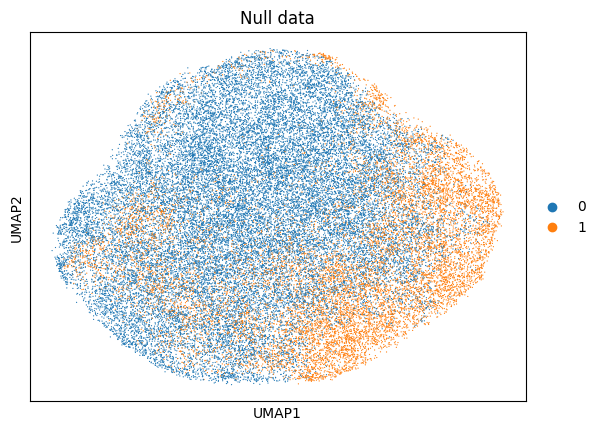

In [21]:
sc.pl.umap(data_null_gen, color=f"leiden_{best_split}", alpha=1, cmap="viridis", title="Null data")
plt.show()

In [22]:
data_null_gen.obs["leiden_best"] = data_null_gen.obs[f"leiden_{best_split}"]

data_null_gen.write(data_path + "/null_data_antibiotics_2.h5ad")

In [23]:
importlib.reload(cd)
clusters = data_gene.obs["leiden_opt"].unique()
DEs_log_gen = {}
pvals_log_gen = {}
fdr = 0.05
rng = np.random.default_rng(1234)

for c in clusters:
    
    X_data_0 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] == c].copy()
    X_data_1 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] != c].copy()
    
    n_cells_0 = X_data_0.shape[0]
    n_cells_1 = X_data_1.shape[0]
    
    X_null_gen_0 = data_null_gen.X[data_null_gen.obs[f"leiden_best"] != "0"]
    X_null_gen_0 = X_null_gen_0[rng.integers(X_null_gen_0.shape[0], size=n_cells_0),:]
    X_null_gen_1 = data_null_gen.X[data_null_gen.obs[f"leiden_best"] == "0"]
    X_null_gen_1 = X_null_gen_1[rng.integers(X_null_gen_1.shape[0], size=n_cells_1),:]
    null_pvals = ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue
    
    pvals_data = ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue
    p_data = pd.DataFrame({"pval_data": pvals_data}, index=data_gene_nonzero.var.index)
    pval_null_gen = pd.DataFrame({"pval_null": null_pvals}, index=data_null_gen.var.index)
    
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=True)
    data_gene_nonzero.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene_nonzero.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene_nonzero.var[f"DE_cluster_{c}_gen"] = (data_gene_nonzero.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_log_gen[c] = DE_TU
    pvals_log_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_log_gen[c])}; Minimum q value: {np.min(pvals_log_gen[c]['q'])}")

Cluster 3 - DE genes: 96; Minimum q value: 0.016129032258064516
Cluster 2 - DE genes: 0; Minimum q value: 0.05263157894736842
Cluster 1 - DE genes: 0; Minimum q value: 0.10256410256410256
Cluster 0 - DE genes: 0; Minimum q value: 0.07692307692307693
Cluster 5 - DE genes: 69; Minimum q value: 0.029411764705882353
Cluster 4 - DE genes: 0; Minimum q value: 0.1111111111111111
Cluster 6 - DE genes: 102; Minimum q value: 0.016666666666666666
Cluster 7 - DE genes: 102; Minimum q value: 0.012987012987012988


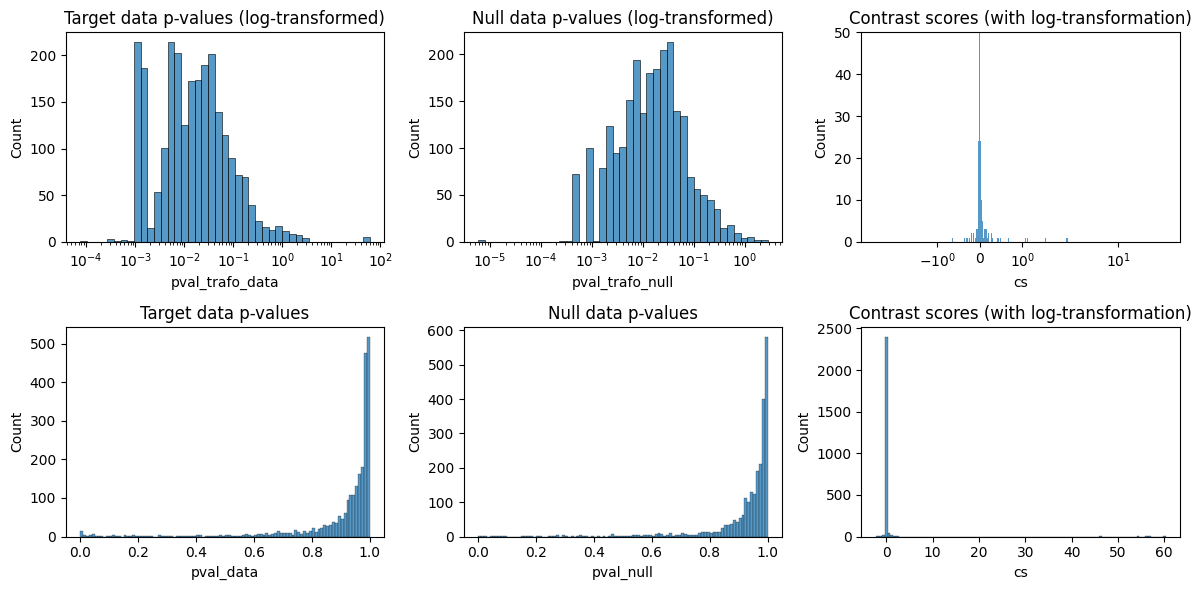

In [24]:
c = "4"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_log_gen[c], x="pval_trafo_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log_gen[c], x="pval_trafo_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog", ylim=(0, 50))

sns.histplot(pvals_log_gen[c], x="pval_data", ax=ax[1,0], bins=100)
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals_log_gen[c], x="pval_null", ax=ax[1,1], bins=100)
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[1,2], bins=100)
ax[1,2].set_title("Contrast scores (with log-transformation)")


plt.tight_layout()
plt.show()

In [25]:
for c in clusters:
    print(f"cluster {c}")
    print(pvals_log_gen[c]["q"].value_counts().sort_index())
    print("")

cluster 3
0.016129     62
0.028571      8
0.033708     19
0.041667      7
0.051020      2
           ... 
0.470805      1
0.471779      3
0.473329      1
0.474877      1
1.000000    852
Name: q, Length: 265, dtype: int64

cluster 2
0.052632     38
0.069767      5
0.088889      2
0.096774     17
0.102564     16
           ... 
0.404070      1
0.404416      1
0.405688      2
0.407857      8
1.000000    753
Name: q, Length: 214, dtype: int64

cluster 1
0.102564     39
0.111111      6
0.127660      2
0.138462     18
0.146667     10
           ... 
0.398961      1
0.400462      1
0.401384      1
0.401611      4
1.000000    746
Name: q, Length: 209, dtype: int64

cluster 0
0.076923     13
0.117647      4
0.120000      8
0.242424      8
0.245937    890
           ... 
0.433196      4
0.435522      7
0.436332      6
0.436661      1
1.000000    771
Name: q, Length: 184, dtype: int64

cluster 5
0.029412      34
0.039216      17
0.043478      18
0.064935       8
0.084337       6
            ... 


In [26]:
pvals_log_gen["3"]

pval_data     pval_null  pval_trafo_data  \
cds-WP_013815099.1-79   0.000000e+00  1.114724e-01              inf   
cds-WP_032430171.1     4.552335e-175  1.003587e-01       174.341766   
cds-WP_004174069.1     3.422822e-173  1.357650e-03       172.465616   
cds-WP_032430073.1      4.975817e-77  4.302564e-01        76.303136   
cds-WP_004174069.1-2    7.364758e-93  2.108407e-17        92.132841   
...                              ...           ...              ...   
cds-WP_002913505.1      2.827324e-01  4.272863e-02         0.548624   
cds-WP_002914160.1      3.128316e-01  4.063962e-02         0.504689   
cds-WP_004183439.1      4.622267e-02  4.167748e-03         1.335145   
cds-WP_032430362.1      1.002075e-01  1.692321e-03         0.999100   
cds-WP_002910105.1      2.072011e-01  1.709239e-03         0.683608   

                       pval_trafo_null          cs         q  
cds-WP_013815099.1-79         0.952833         inf  0.016129  
cds-WP_032430171.1            0.998445  173.343321  0.016129  
cds-WP_004174069.1            2.867212  169.598404  0.016129  
cds-WP_032430073.1            0.366273   75.936863  0.016129  
cds-WP_004174069.1-2         16.676046   75.456796  0.016129  
...                                ...         ...       ...  
cds-WP_002913505.1            1.369281   -0.820657  1.000000  
cds-WP_002914160.1            1.391050   -0.886361  1.000000  
cds-WP_004183439.1            2.380099   -1.044954  1.000000  
cds-WP_032430362.1            2.771517   -1.772417  1.000000  
cds-WP_002910105.1            2.767197   -2.083589  1.000000  

[2484 rows x 6 columns]

In [27]:
data_gene_nonzero.uns["ClusterDE_results"] = pvals_log_gen

data_gene_nonzero.uns["ClusterDE_results"]['params'] = {'groupby': 'leiden_opt',
  'reference': 'rest',
  'use_raw': False,
  'layer': None,
}

In [28]:
data_gene_nonzero.write(data_path + "/antibiotics_data_processed_cluster.h5ad")

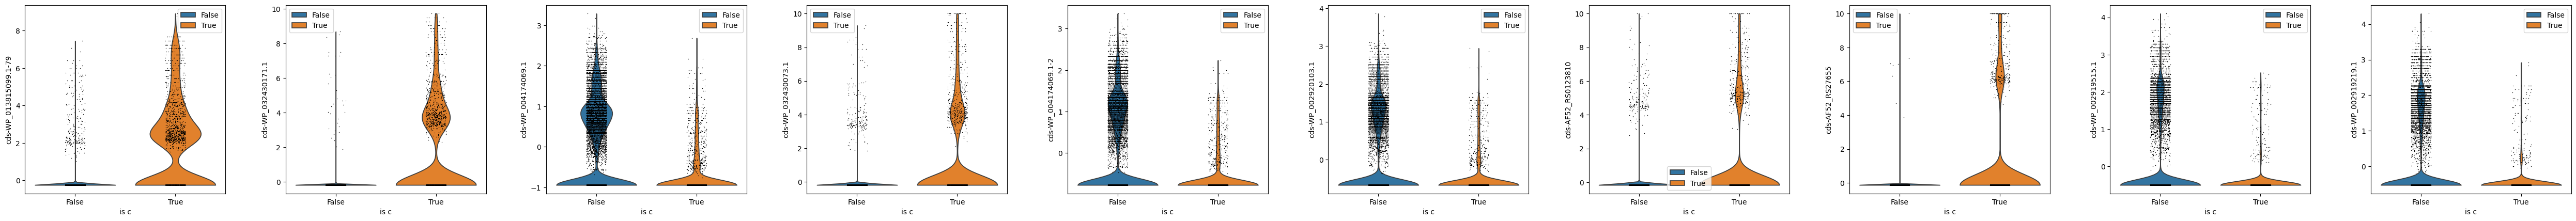

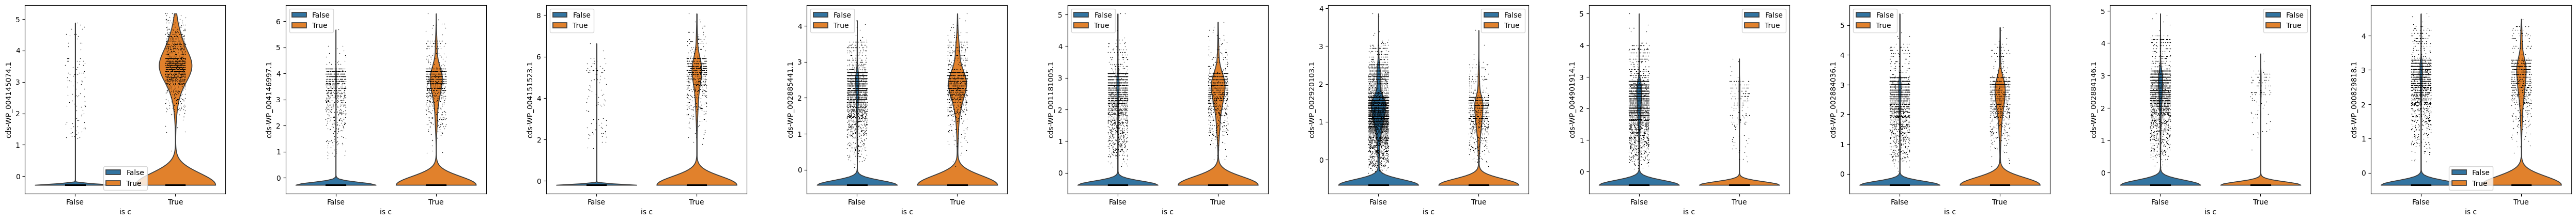

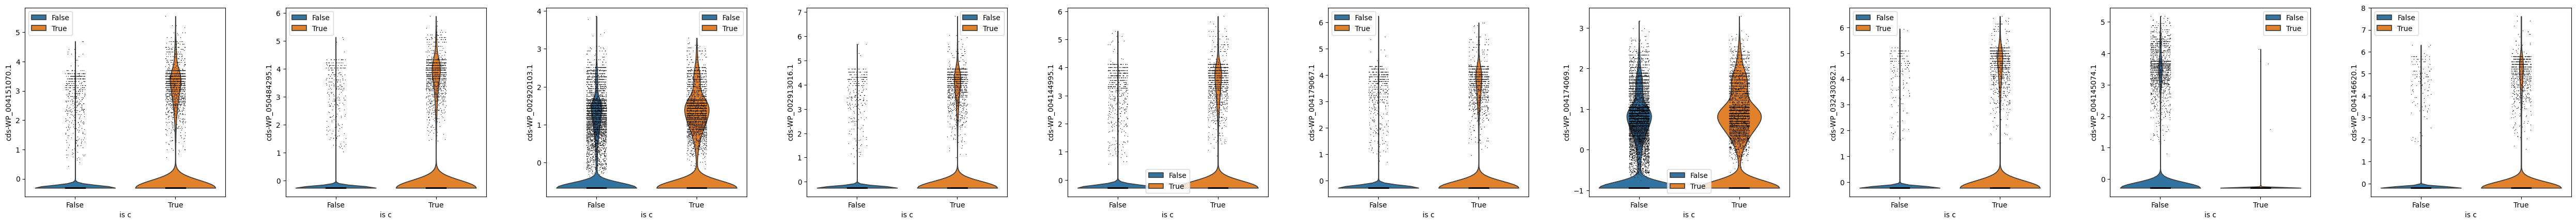

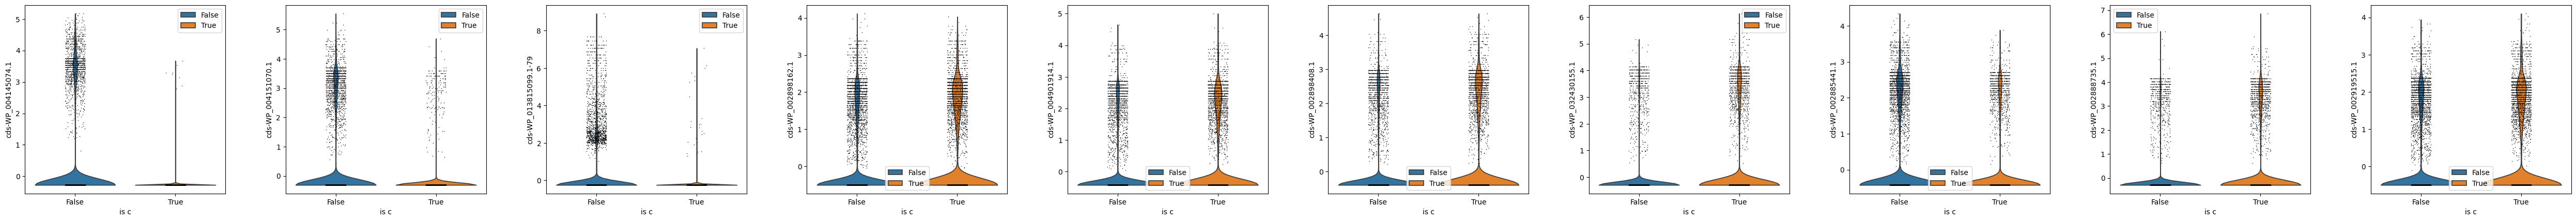

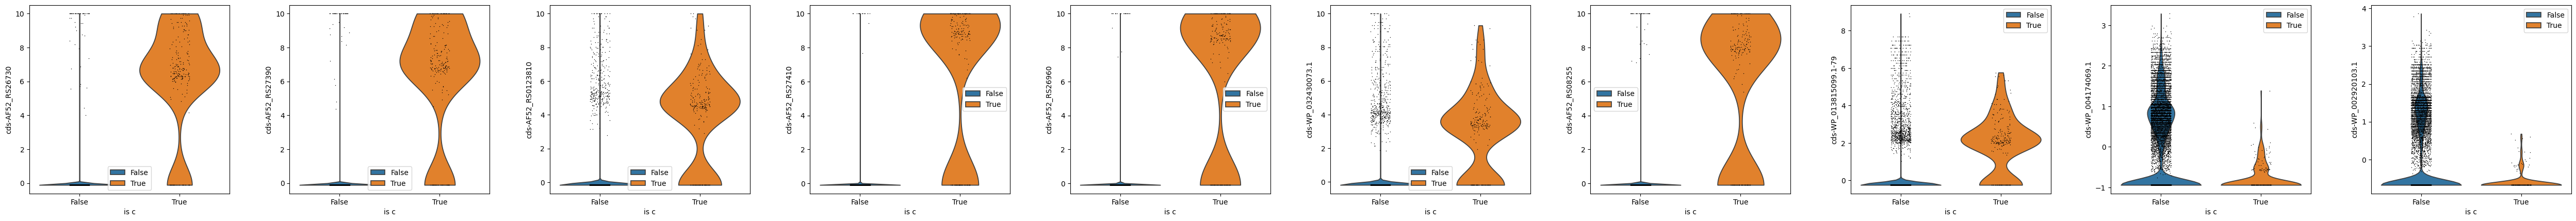

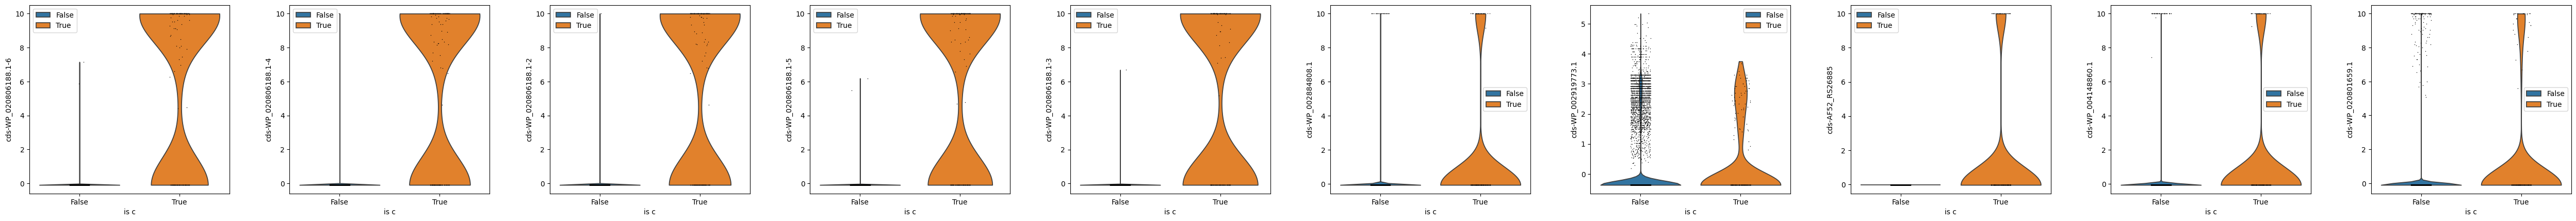

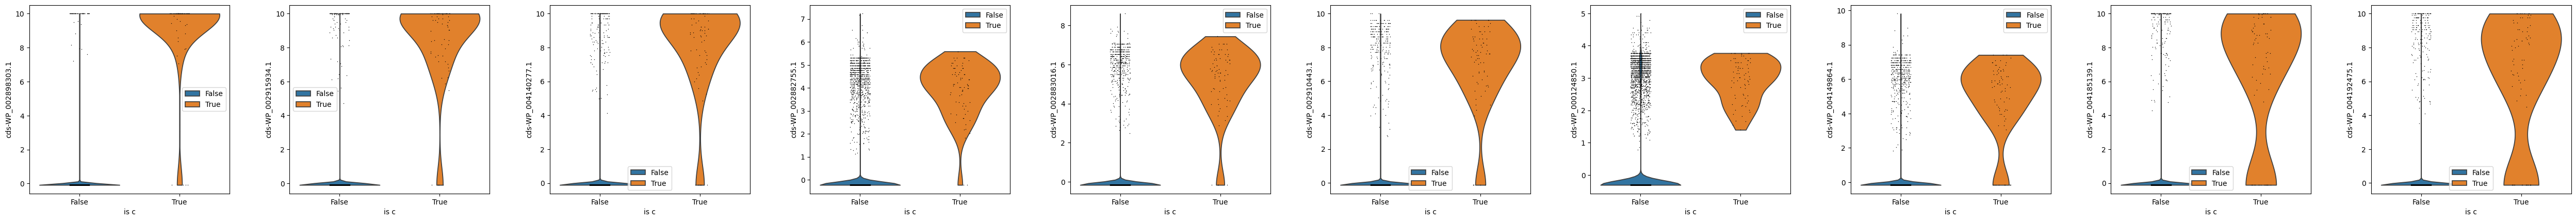

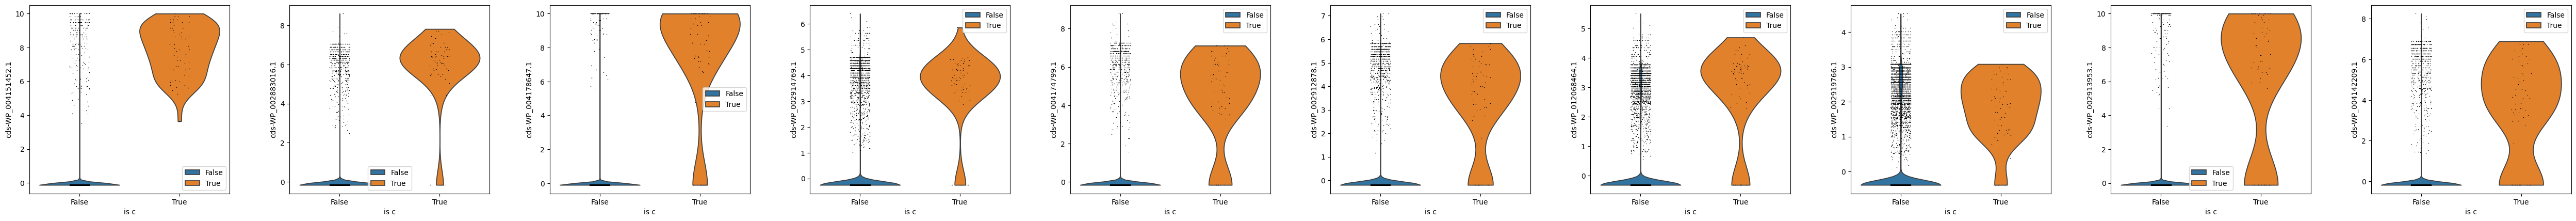

In [29]:
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].iloc[:10,:].index.tolist()
    data_gene_nonzero.obs["is_c"] = pd.Categorical([x==c for x in data_gene_nonzero.obs["leiden_opt"]])
    with plt.rc_context({"figure.figsize": (5, 5)}):
        sc.pl.violin(data_gene_nonzero, keys=plot_genes, groupby="is_c", multi_panel=True)

In [30]:
data_gene.var

n_cells_by_counts  mean_counts  log1p_mean_counts  \
cds-AF52_RS00165                   13     0.000662           0.000662   
cds-AF52_RS00180                    2     0.000102           0.000102   
cds-AF52_RS00620                   14     0.000713           0.000713   
cds-AF52_RS01010                    2     0.000102           0.000102   
cds-AF52_RS01075                    3     0.000153           0.000153   
...                               ...          ...                ...   
cds-WP_187079188.1                  9     0.000458           0.000458   
cds-WP_187079189.1                 24     0.001273           0.001272   
cds-WP_187079194.1                 39     0.002037           0.002035   
cds-WP_187079196.1                 21     0.001171           0.001171   
cds-WP_187079197.1                 11     0.000560           0.000560   

                    pct_dropout_by_counts  total_counts  log1p_total_counts  \
cds-AF52_RS00165                99.933802          13.0            2.639057   
cds-AF52_RS00180                99.989816           2.0            1.098612   
cds-AF52_RS00620                99.928710          14.0            2.708050   
cds-AF52_RS01010                99.989816           2.0            1.098612   
cds-AF52_RS01075                99.984723           3.0            1.386294   
...                                   ...           ...                 ...   
cds-WP_187079188.1              99.954170           9.0            2.302585   
cds-WP_187079189.1              99.877788          25.0            3.258096   
cds-WP_187079194.1              99.801405          40.0            3.713572   
cds-WP_187079196.1              99.893064          23.0            3.178054   
cds-WP_187079197.1              99.943986          11.0            2.484907   

                    n_cells  var_counts  is_scd_outlier  nb_overdisp  ...  \
cds-AF52_RS00165         13    0.000661           False     0.015929  ...   
cds-AF52_RS00180          2    0.000102           False     0.000202  ...   
cds-AF52_RS00620         14    0.000713           False     0.026059  ...   
cds-AF52_RS01010          2    0.000102           False     0.000202  ...   
cds-AF52_RS01075          3    0.000153           False     0.000238  ...   
...                     ...         ...             ...          ...  ...   
cds-WP_187079188.1        9    0.000458           False     0.021694  ...   
cds-WP_187079189.1       24    0.001373           False     0.024587  ...   
cds-WP_187079194.1       39    0.002134           False     0.028569  ...   
cds-WP_187079196.1       21    0.001374           False     0.019140  ...   
cds-WP_187079197.1       11    0.000560           False     0.016529  ...   

                    product_accession  \
cds-AF52_RS00165                  NaN   
cds-AF52_RS00180                  NaN   
cds-AF52_RS00620                  NaN   
cds-AF52_RS01010                  NaN   
cds-AF52_RS01075                  NaN   
...                               ...   
cds-WP_187079188.1     WP_187079188.1   
cds-WP_187079189.1     WP_187079189.1   
cds-WP_187079194.1     WP_187079194.1   
cds-WP_187079196.1     WP_187079196.1   
cds-WP_187079197.1     WP_187079197.1   

                                                                 name  symbol  \
cds-AF52_RS00165                                  diguanylate cyclase     NaN   
cds-AF52_RS00180                         PTS transporter subunit EIIC     NaN   
cds-AF52_RS00620            sugar ABC transporter ATP-binding protein     NaN   
cds-AF52_RS01010                                                  NaN     NaN   
cds-AF52_RS01075                               DUF5347 family protein     NaN   
...                                                               ...     ...   
cds-WP_187079188.1                            DNA replication protein     NaN   
cds-WP_187079189.1                                     ribonuclease D     rnd   
cds-WP_187079194.1                             

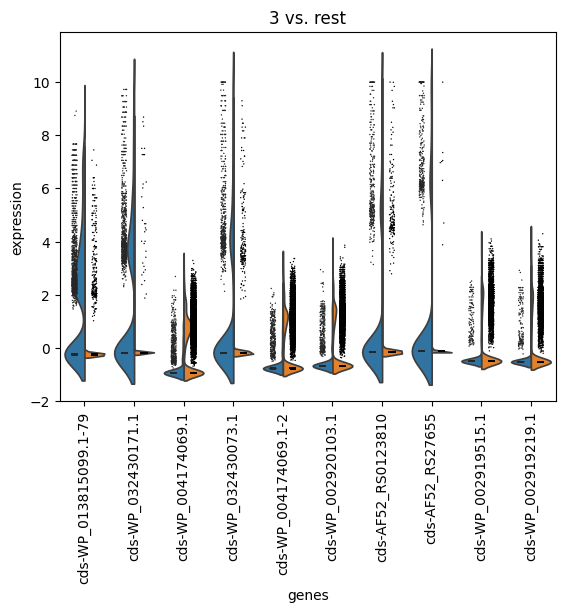

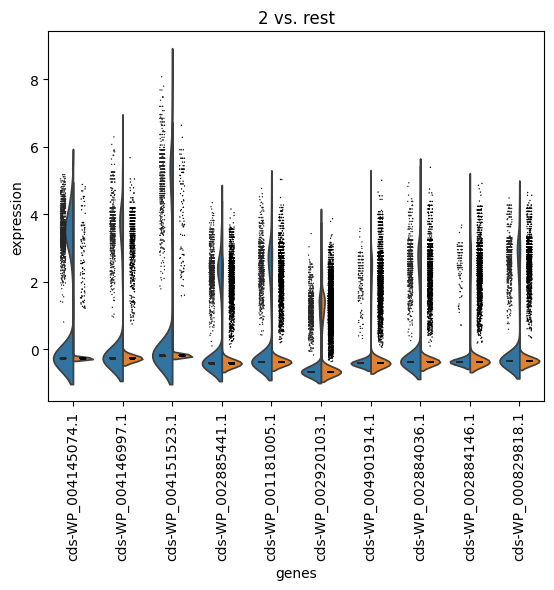

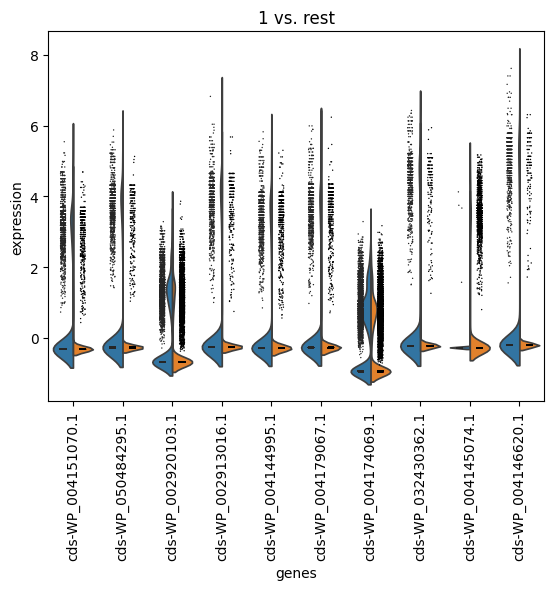

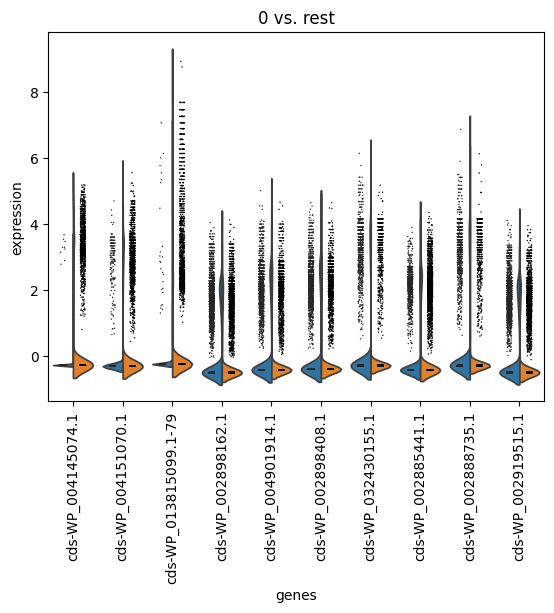

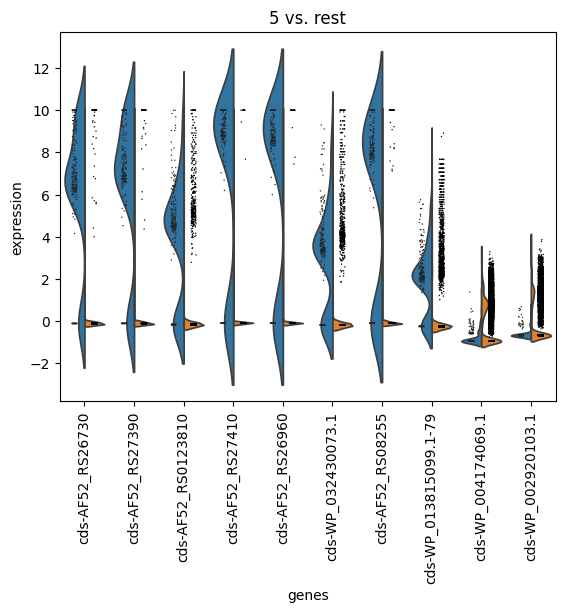

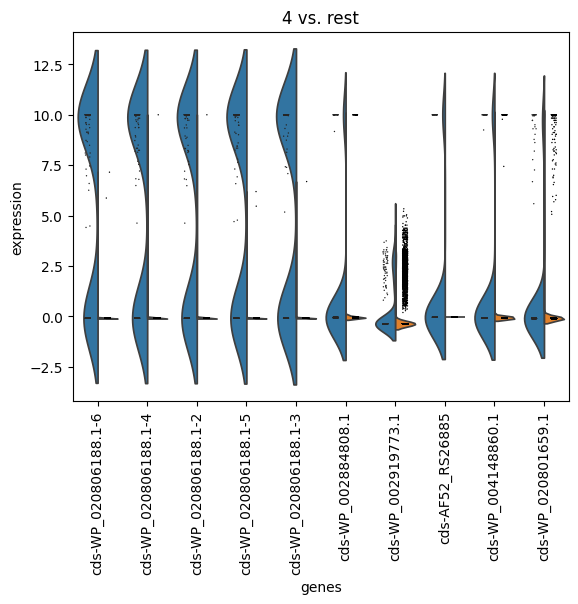

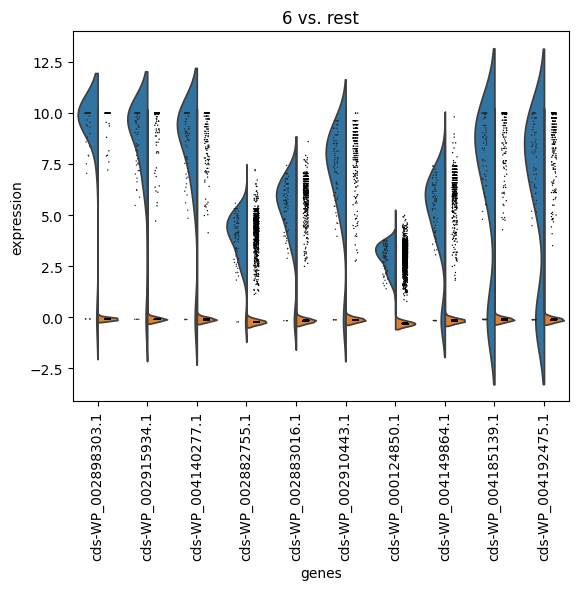

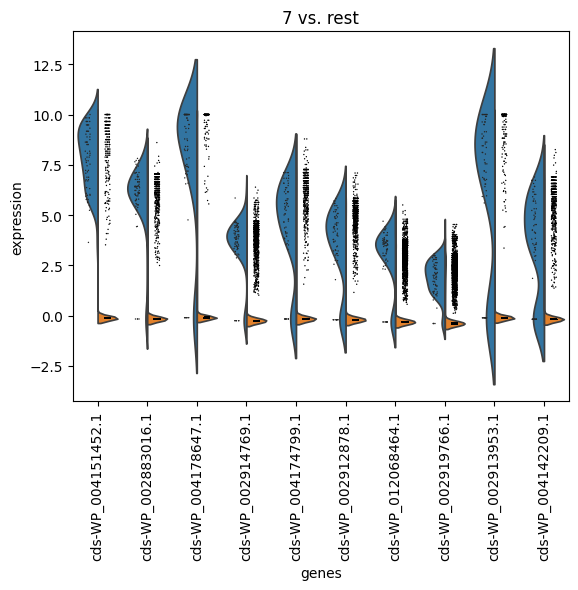

In [31]:
n_genes = 10
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].iloc[:n_genes,:].index.tolist()
    sc.pl.rank_genes_groups_violin(data_gene_nonzero, gene_names=plot_genes, key="ClusterDE_results", groups=c)

In [32]:
all_marker_genes = []
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].iloc[:n_genes,:].index.tolist()
    all_marker_genes += plot_genes
    print(f"Cluster {c}")
    print(data_gene.var.loc[plot_genes, ["locus_tag", "name", "symbol"]])

Cluster 3
                            locus_tag  \
cds-WP_013815099.1-79    AF52_RS22855   
cds-WP_032430171.1       AF52_RS24890   
cds-WP_004174069.1       AF52_RS08475   
cds-WP_032430073.1       AF52_RS09075   
cds-WP_004174069.1-2     AF52_RS08475   
cds-WP_002920103.1       AF52_RS08480   
cds-AF52_RS0123810     AF52_RS0123810   
cds-AF52_RS27655         AF52_RS27655   
cds-WP_002919515.1       AF52_RS08350   
cds-WP_002919219.1       AF52_RS08335   

                                                             name symbol  
cds-WP_013815099.1-79  IS5-like element IS903B family transposase    NaN  
cds-WP_032430171.1                         IS5 family transposase    NaN  
cds-WP_004174069.1                           elongation factor Tu    tuf  
cds-WP_032430073.1     IS5-like element IS903B family transposase    NaN  
cds-WP_004174069.1-2                         elongation factor Tu    tuf  
cds-WP_002920103.1                            elongation factor G   fusA  
cds-AF52_RS01

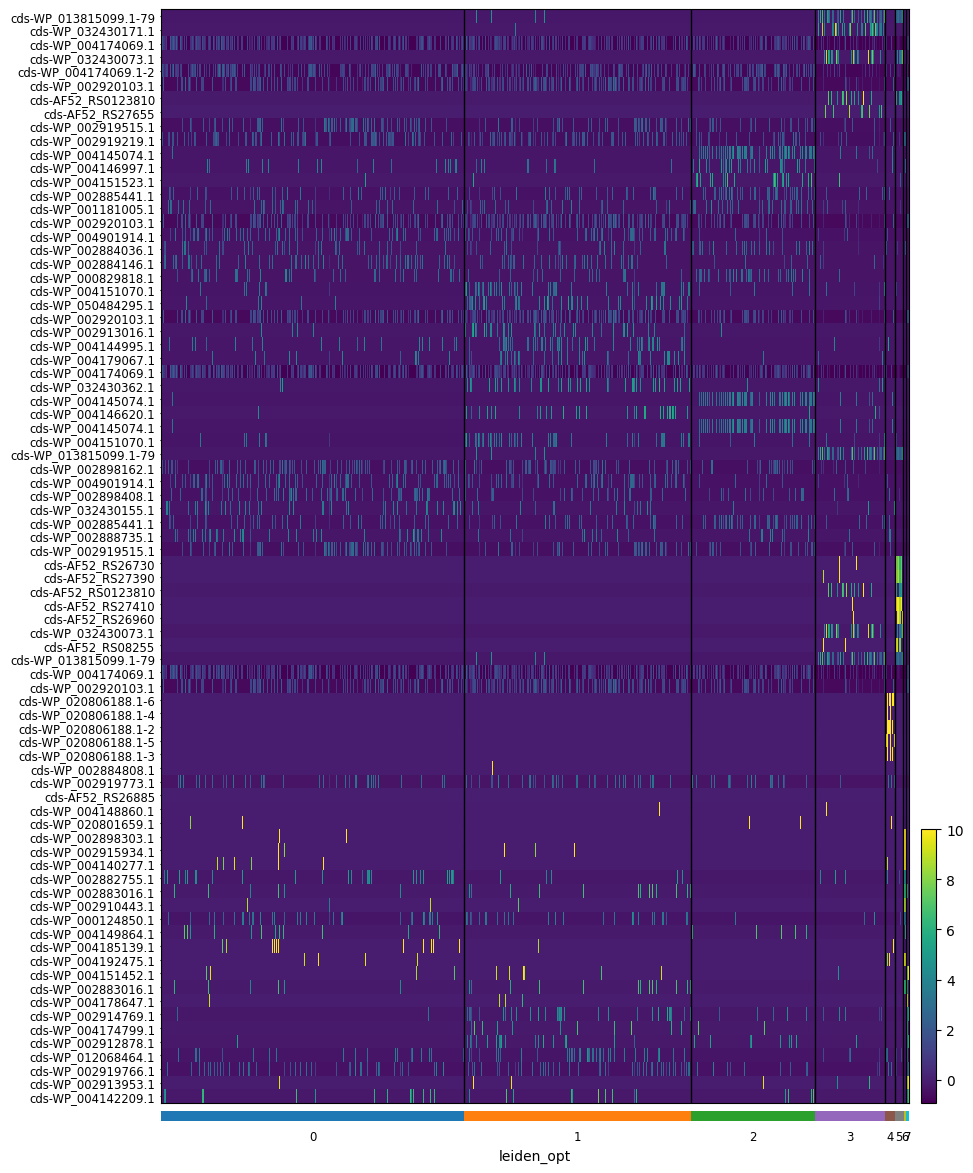

In [33]:
sc.pl.heatmap(data_gene_nonzero, all_marker_genes, groupby='leiden_opt', swap_axes=True, show_gene_labels=True)